### SVM + TF-IDF(상위 빈도 100)

In [2]:
import ujson
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from pandas import DataFrame
%matplotlib inline
sns.set(font_scale=2)

FEATURE_POS = ["NNG", "VV", "VA", "MDT", "MAG"]
POS_KEY = "lyric_pos"
LABEL_KEY = "genre"

def read_documents_with_labels(input_file_name):
    """주어진 이름을 파일에서 문서와 레이블들을 읽어서 돌려준다."""
    
    documents = []
    labels = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            words = []
            json_obj = ujson.loads(line)
            label = json_obj[LABEL_KEY]
            labels.append(label)

            for sent_anal in json_obj[POS_KEY]:
                for word, pos in sent_anal:
                    if pos not in FEATURE_POS:
                        continue

                    # 형태소 어형과 품사를 하나의 문자열로 결합하여 사용한다.
                    words.append(word + "/" + pos)

            document = " ".join(words)
            documents.append(document)

    # 파이썬 리스트를 numpy 모듈의 배열(array)로 변환 
    documents = np.asarray(documents)
    labels = np.asarray(labels)
    
    return documents, labels


def build_pipeline():
    """벡터라이저와 분류자의 파이프라인을 생성하여 돌려준다."""
    
    vectorizer = TfidfVectorizer(max_features=100, norm=None, use_idf=True, tokenizer=str.split)
    
    svm = SVC(kernel='linear', C=1.0, random_state=42) 
    pipeline = Pipeline([
        ('vect', vectorizer),
        ('svm', svm),
    ])
    
    return pipeline


def main():
    global pred_labels, test_labels
    """뉴스 문서 집합에 대한 카데고리 분류를 수행한다."""
    
    input_file_name = r"lyrics_pos.txt"
    documents, labels = read_documents_with_labels(input_file_name)
    pipe_line = build_pipeline()
    
    VALIDATION_SPLIT = 0.3

    np.random.seed(1234)

    perm = np.random.permutation(len(documents))
    idx_train = perm[:int(len(documents)*(1-VALIDATION_SPLIT))]
    idx_test = perm[int(len(documents)*(1-VALIDATION_SPLIT)):]

    train_documents = documents[idx_train]
    train_labels = labels[idx_train]
    test_documents = documents[idx_test]
    test_labels = labels[idx_test]

    pipe_line.fit(train_documents, train_labels)
    pred_labels = pipe_line.predict(test_documents)

    accuracy = accuracy_score(test_labels, pred_labels)
 
    print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))
    
    
# 실행 
main()


The accuracy on testing set is: 46.1%


Predicted    0    1    2    3   4    5
True                                  
0          216   70   56   48  54   42
1           96  184   69   16  25   71
2           58   56  248   25   8   43
3           24    5    9  344  18   29
4          120   46   22   82  97  107
5           71   65   53   50  55  190


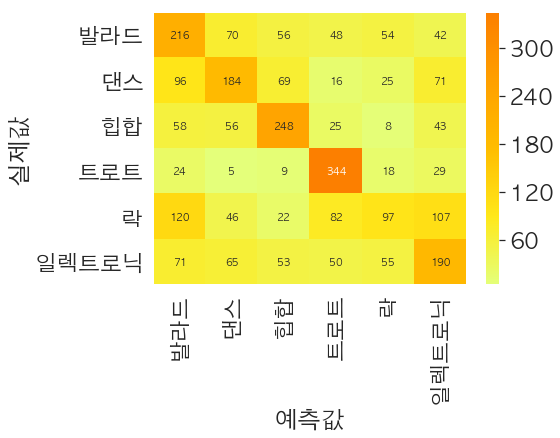

In [17]:
#예측결과 행렬 출력(heatmap 사용)
import pandas as pd
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False


result = pd.crosstab(test_labels, pred_labels, rownames=['True'], colnames=['Predicted'], margins=False)
print(result)

result.index=['발라드','댄스','힙합','트로트','락','일렉트로닉']
result.columns=['발라드','댄스','힙합','트로트','락','일렉트로닉']
result.index.name="실제값"
result.columns.name="예측값"

plt.figure(figsize=(7,5))
sns.heatmap(result, annot=True, cmap="Wistia", fmt="d")


### LSTM +word2vec

In [5]:
#형태소 분석 완료한 가사 텍스트 불러와서 최종 데이터 생성

POS_KEY = "lyric_pos"
LABEL_KEY = "genre"

def read_documents_with_labels(input_file_name):
    """주어진 이름을 파일에서 문서와 레이블들을 읽어서 돌려준다."""
    
    documents = ["lyric_pos"]
    labels = ["genre"]

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)
            label = json_obj[LABEL_KEY]
            labels.append(label)

            for sent_anal in json_obj[POS_KEY]:
                for word, pos in sent_anal:
                    morphs.append(word)

            document = " ".join(morphs)
            documents.append(document)

    return documents, labels

    
def main():
    """가사 파일 형태소 분석 후 json 형태의 파일로 저장된 파일을 이용해 최종 가사 분류 데이터 생성"""
    
    input_file_name = r"lyrics_pos.txt"
    output_file_name = r"lyric_class_data.tsv"

    documents, labels = read_documents_with_labels(input_file_name)
    
    with open(output_file_name, "w", encoding="utf-8") as output_file:
            
        for document, label in zip(documents, labels): 
            outputs = [document, str(label)]
            print("\t".join(outputs), file=output_file)
                    
#
main()


In [6]:
# 가사 장르 분류 데이터 파일 불러오기

import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

DATA_FILE=r"lyric_class_data.tsv"

data_file = pd.read_csv(DATA_FILE, delimiter = "\t")

list_sentences = data_file["lyric_pos"]

comments = []

for line in list_sentences:
    line = str(line)
    comments.append(line)

y = data_file["genre"]

print(len(comments))
#9238

Using TensorFlow backend.


9238


In [7]:
# Tokenizer() 함수 이용해 띄어쓰기 기준으로 단어 토큰화
#워드투백(세로:워드, 가로: 차원)

MAX_NB_WORDS = 4340

tokenizer = Tokenizer(num_words=MAX_NB_WORDS
                      ,filters='!"#$%()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
                      ,lower=False)

tokenizer.fit_on_texts(comments)

# texts_to_sequences() 함수 이용해 단어를 숫자로 변환 

sequences = tokenizer.texts_to_sequences(comments)

# 문장을 토큰화 하여 단어의 index 생성 (word_index 구성: key= word, value = word의 고유번호)

MAX_SEQUENCE_LENGTH = 140

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
#post : padding을 뒤에 붙이는걸로, 141 뒤로는 전부 버림
print('Shape of data tensor:', data.shape) #shape로 차원을 확인
print('Shape of label tensor:', y.shape)


Found 37460 unique tokens
Shape of data tensor: (9238, 140)
Shape of label tensor: (9238,)


In [9]:
# 워드 임베딩 모델의 결과 파일 불러오기 
#워드투백 사용한 데이터를 가져와서 재매칭

from gensim.models.keyedvectors import KeyedVectors
import numpy as np

print('Preparing word embedding matrix')

EMBEDDING_DIM = 300

EMBEDDING_FILE = "skipgram_300feaures_3window_5count_wiki"

word_vectors = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

# prepare embedding matrix
nb_words = len(word_index)

#embedding_matrix = np.random.uniform(-1, 1, (nb_words, EMBEDDING_DIM))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i+1 > MAX_NB_WORDS:
        continue
        
    if word in word_vectors:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


Preparing word embedding matrix
Null word embeddings: 35052


In [10]:
# 훈련용 데이터와 검증용 데이터 나누기

VALIDATION_SPLIT = 0.3

np.random.seed(1234)

perm = np.random.permutation(len(data))
idx_train = perm[:int(len(data)*(1-VALIDATION_SPLIT))]
idx_test = perm[int(len(data)*(1-VALIDATION_SPLIT)):]

train_data=data[idx_train]
test_data=data[idx_test]

train_y=y[idx_train]
test_y=y[idx_test]

print(train_data.shape, test_data.shape, train_y.shape, test_y.shape)


(6466, 140) (2772, 140) (6466,) (2772,)


In [11]:
"""LSTM 모델 구축 및 훈련"""

import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

In [12]:
# 성과 지표 추가 

from keras import backend as K
from keras import metrics


def mcor(y_true, y_pred):
    # matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))


In [13]:
# 워드 임베딩 레이어 생성 

embedding_layer = Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix],  
                            input_length=MAX_SEQUENCE_LENGTH, trainable=True)

# LSTM 레이어 생성 

num_lstm = 100

lstm_layer = LSTM(num_lstm, return_sequences=True)

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences= embedding_layer(input_layer)

# LSTM 모델 생성 

from keras.layers import Flatten

num_dense = 300
x = lstm_layer(embedded_sequences)
merged = BatchNormalization()(x)
merged = Flatten()(merged)
merged = Dense(num_dense, activation='relu')(merged)
merged = BatchNormalization()(merged)
LSTM_MODEL = Dense(6, activation='softmax')(merged)


Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# LSTM 모델 훈련

lstm_model = Model(inputs=[input_layer], outputs=LSTM_MODEL)

lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', recall, precision, f1])

print (lstm_model.summary())

hist = lstm_model.fit(train_data, train_y, epochs=3, batch_size=64, shuffle=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 300)          11238000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 140, 100)          160400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 140, 100)          400       
_________________________________________________________________
flatten_1 (Flatten)          (None, 14000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               4200300   
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
__________

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False
# LSTM 모델 검증
y_pred = lstm_model.predict(test_data)
print(y_pred)
classes = np.argmax(y_pred, axis=1)
print(classes)

result = pd.crosstab(test_y, classes, rownames=['True'], colnames=['Predicted'], margins=False)
result.index=['발라드','댄스','힙합','트로트','락','일렉트로닉']
#result.columns=['ballad','dance','hiphop','trot','rock','electronic']
result.columns=['발라드','댄스','힙합','트로트','락','일렉트로닉']
result.index.name="실제값"
result.columns.name="예측값"

plt.figure(figsize=(7,5))
sns.heatmap(result, annot=True, cmap="Wistia", fmt="d")

loss_and_metrics = lstm_model.evaluate(test_data, test_y, batch_size = 64)

print('accuracy: ' + str(loss_and_metrics[1]))
print('recall: ' + str(loss_and_metrics[2]))
print('precision: ' + str(loss_and_metrics[3]))
print('f1: ' + str(loss_and_metrics[4]))